In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
# first dataset comes from http://medata.gov.co/dataset/tarifa-promedio-mensual-pesos-colombianos/resource/86c2c034-b64a-42f5-bb45-91d41a05998c#{} , the data es is about of the Average monthly rate for hotels in Medellin
import requests
import json

response = requests.get("http://medata.gov.co/api/action/datastore/search.json?resource_id=86c2c034-b64a-42f5-bb45-91d41a05998c&limit=93")
jsonData = json.loads(response.text)

data1 = pd.DataFrame(jsonData["result"]["records"])

data1.head()

,periodo,indice,valor
0,201201,tarifa_ocupa_hotelera,106056
1,201202,tarifa_ocupa_hotelera,97827
2,201203,tarifa_ocupa_hotelera,101663
3,201204,tarifa_ocupa_hotelera,97771
4,201205,tarifa_ocupa_hotelera,96885


In [4]:
# second dataset comes from https://www.datos.gov.co/Econom-a-y-Finanzas/Tasa-de-Cambio-Representativa-del-Mercado-TRM/32sa-8pi3, is about the exchange rate of dolars and Colombian currency (Colombian peso)
data2 = pd.read_csv("https://www.datos.gov.co/resource/32sa-8pi3.csv?$limit=8000")

data2.head()

,valor,unidad,vigenciadesde,vigenciahasta
0,2850.98,COP,2002-10-09T00:00:00.000,2002-10-09T00:00:00.000
1,2854.04,COP,2002-10-10T00:00:00.000,2002-10-10T00:00:00.000
2,2870.63,COP,2002-10-11T00:00:00.000,2002-10-11T00:00:00.000
3,2861.16,COP,2002-10-12T00:00:00.000,2002-10-15T00:00:00.000
4,2852.99,COP,2002-10-16T00:00:00.000,2002-10-16T00:00:00.000


In [5]:
# cleaning data1
data1["date"] = data1["periodo"].apply(lambda date: pd.Timestamp(year=int(date[:4]), month=int(date[4:]), day=1))
data1["valor"] = pd.to_numeric(data1["valor"])

data1.query("valor != 0", inplace=True)
data1.drop(columns=["indice"], inplace=True)

data1.head()

,periodo,valor,date
0,201201,106056,2012-01-01
1,201202,97827,2012-02-01
2,201203,101663,2012-03-01
3,201204,97771,2012-04-01
4,201205,96885,2012-05-01


In [6]:
# cleaning data2
data2["vigenciadesde"] = pd.to_datetime(data2["vigenciadesde"])
data2["vigenciahasta"] = pd.to_datetime(data2["vigenciahasta"])

data2.query("vigenciadesde >= '2012-01-01' and vigenciahasta <= '2019-09-30'", inplace=True)

missing = []
for i, row in data2.query("vigenciadesde != vigenciahasta").iterrows():
    missing += [{"valor": row["valor"], "date": date} for date in pd.date_range(row["vigenciadesde"], row["vigenciahasta"], closed="right")]

data2.drop(columns=["unidad", "vigenciahasta"], inplace=True)
data2.rename(columns={"vigenciadesde": "date"}, inplace=True)
data2 = pd.concat([data2, pd.DataFrame(missing)])
data2.sort_values("date", inplace=True, ignore_index=True)

# getting values to compare
data2["date"] = data2["date"].apply(lambda date: pd.Timestamp(year=date.year, month=date.month, day=1))

data2 = data2.groupby("date", as_index=False).mean()
data2.query("date != '2014-12-01'", inplace=True)

data2.head()

,date,valor
0,2012-01-01,1843.701786
1,2012-02-01,1782.754828
2,2012-03-01,1766.331613
3,2012-04-01,1774.249000
4,2012-05-01,1793.276774


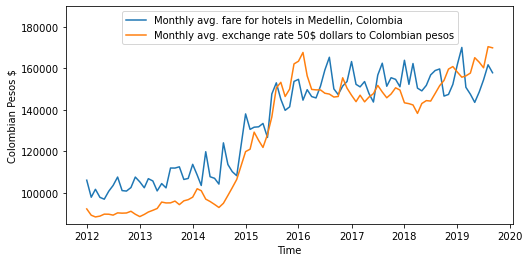

In [59]:
plt.figure(facecolor="w", figsize=(8,4))
ax1 = plt.gca()

ax1.plot(data1["date"], data1["valor"], label="Monthly avg. fare for hotels in Medellin, Colombia")
ax1.plot(data2["date"], data2["valor"]*50, label="Monthly avg. exchange rate 50$ dollars to Colombian pesos")
ax1.set_ylim([85000, 190000])
# ax1.set_xlim(data1["date"].agg(["min", "max"]))
ax1.set_ylabel("Colombian Pesos $")
ax1.set_xlabel("Time")
ax1.legend(loc='upper center')

# plt.savefig("plot.png")
plt.show()

In [41]:
# fig, (ax1, ax2, ax3) = plt.subplots(1, 3, facecolor="w", figsize=(15,7))
# import matplotlib.gridspec as gridspec

# plt.figure(facecolor="w", figsize=(15,15))
# gspec = gridspec.GridSpec(2, 4)
# ax1 = plt.subplot(gspec[0 , 0:2])
# ax2 = plt.subplot(gspec[0 , 2:])
# ax3 = plt.subplot(gspec[1 , 1:3])

# ax1.plot(data1["date"], data1["valor"])
# ax1.set_title("Monthly avg. fare for hotels in Medellin")
# ax1.set_ylabel("Colombian pesos")
# ax1.set_xlabel("Time")

# ax2.plot(data2["date"], data2["valor"], color="r")
# ax2.set_title("Monthly avg. exchange rate 1 dollar to Colombian pesos")
# ax2.set_xlabel("Time")
# # ax2.set_ylabel("Colombian pesos")

# ax3.scatter(data2["valor"], data1["valor"])
# ax3.text(s=f"Corr = {round(data1['valor'].corr(data2['valor']), 3)}", x=1800, y=160000, fontsize=15)

# plt.show()

In [50]:
# fig, (ax1, ax2) = plt.subplots(1, 2, facecolor="w", figsize=(14,5))

# ax1.plot(data1["date"], data1["valor"], label="Monthly avg. fare for hotels in Medellin, Colombia")
# ax1.plot(data2["date"], data2["valor"]*50, label="Monthly avg. exchange rate 50$ dollars to Colombian pesos")
# ax1.set_ylim([85000, 190000])
# ax1.set_ylabel("Colombian Pesos $")
# ax1.set_xlabel("Time")
# ax1.legend()

# ax2.scatter(data1["valor"], data2["valor"]*50)
# ax2.text(s=f"Correlation Coef. = {round(data1['valor'].corr(data2['valor']), 3)}", x=100000, y=160000, fontsize=12)
# ax2.set_xticks([100000, 120000, 140000, 160000])
# ax2.set_xlabel("Colombian Pesos $")
# ax2.set_ylabel("Colombian Pesos $")
# ax2.set_title("")

# plt.show() 

### Is there any connection between dollar exchange rate and the fare for hotels in Medellin, Colombia ?

In the plot are the Monthly average fare for hotels in Medellin, Colombia and the Monthly average exchange rate of 50$ dollars to Colombian pesos (I show 50$ dollars instead of 1$ because 1$ dollar exchange rate doesn't look good in the scale of the data, and I tried to follow the Cairo’s principles), in the plot we see when dollar goes up the fare goes up to, and generally we see in the plot that the fare follows the trend of the dollar.

### Cairo's principle
truthfulness: I took the data from government sources, so it would be expected that the data was reliable, and the data was not modified in misleading ways, I showed the exchange rate of 50$ dollars instead of 1$ so that the reader can compare the data in the same scale.

beauty: I used colors to differentiate the data and I tried that the plot looked clean

functionality: I chose a line plot because the line plot represent correctly the data and it shows the date of the data

insightfulness: I think that the plot makes the reader to understand fast what the plot is trying to communicate